# Introducción
En este tutorial vamos a utilizar machine learning para intentar predecir si un tipo de tumor es _benigno_ o _maligno_. Esto lo haremos utilizando el algoritmo [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) más conocido como KNN o K vecinos más cercanos en español. Este algoritmo se puede usar tanto en problemas de clasificación, como el que nos ocupa en este momento, o así tambien de regresión.

La idea en la que se basa es realmente muy simple, y consiste en mirar los K vecinos más cercanos y elegir la etiqueta de una nueva observación en base a las etiquetas de los vecinos. 

Generalmente se dice que es un algoritmo perezoso, ya que no construye un modelo, sino que almacena la información de todas las observaciones en memoria.

## Obtención del dataset

- Carga de librerías necesarias

In [124]:
library(ggplot2)
library(caret)
library(class)
library(RCurl)
library(ggthemr)
ggthemr('fresh')


Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

- Carga del dataset. Leemos el dataset directamente desde la web, y lo almacenamos en un [data.frame](https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/data.frame) de R.

In [125]:
UCI_data_URL <- getURL('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data')
names <- c('id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst')
breast_cancer <- read.table(textConnection(UCI_data_URL), sep = ',', col.names = names)

## Exploración del dataset
A continuación algunos comandos básicos que forman parte del **Análisis Exploratorio de Datos**, probablemente dedique un post a hablar de esto, pero mas adelante.

In [126]:
str(breast_cancer)  # Información del tipo de dato al que pertenece cada variable
dim(breast_cancer)  # Cantidad de filas y columnas (muestras y variables)

'data.frame':	569 obs. of  32 variables:
 $ id_number              : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  18,0 20,6 19,7 11,4 20,3 ...
 $ texture_mean           : num  10,4 17,8 21,2 20,4 14,3 ...
 $ perimeter_mean         : num  122,8 132,9 130,0 77,6 135,1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0,1184 0,0847 0,1096 0,1425 0,1003 ...
 $ compactness_mean       : num  0,2776 0,0786 0,1599 0,2839 0,1328 ...
 $ concavity_mean         : num  0,3001 0,0869 0,1974 0,2414 0,1980 ...
 $ concave_points_mean    : num  0,1471 0,0702 0,1279 0,1052 0,1043 ...
 $ symmetry_mean          : num  0,242 0,181 0,207 0,260 0,181 ...
 $ fractal_dimension_mean : num  0,0787 0,0567 0,0600 0,0974 0,0588 ...
 $ radius_se              : num  1,095 0,543 0,746 0,496 0,757 ...
 $ texture_se    

[1] 569  32

El comando `summary` es una forma muy sencilla de obtener estadísticas descriptivas de cada variable de nuestro dataset.

In [127]:
summary(breast_cancer)

   id_number         diagnosis  radius_mean      texture_mean  
 Min.   :     8670   B:357     Min.   : 6,981   Min.   : 9,71  
 1st Qu.:   869218   M:212     1st Qu.:11,700   1st Qu.:16,17  
 Median :   906024             Median :13,370   Median :18,84  
 Mean   : 30371831             Mean   :14,127   Mean   :19,29  
 3rd Qu.:  8813129             3rd Qu.:15,780   3rd Qu.:21,80  
 Max.   :911320502             Max.   :28,110   Max.   :39,28  
 perimeter_mean     area_mean      smoothness_mean   compactness_mean 
 Min.   : 43,79   Min.   : 143,5   Min.   :0,05263   Min.   :0,01938  
 1st Qu.: 75,17   1st Qu.: 420,3   1st Qu.:0,08637   1st Qu.:0,06492  
 Median : 86,24   Median : 551,1   Median :0,09587   Median :0,09263  
 Mean   : 91,97   Mean   : 654,9   Mean   :0,09636   Mean   :0,10434  
 3rd Qu.:104,10   3rd Qu.: 782,7   3rd Qu.:0,10530   3rd Qu.:0,13040  
 Max.   :188,50   Max.   :2501,0   Max.   :0,16340   Max.   :0,34540  
 concavity_mean    concave_points_mean symmetry_mean   

## Preprocesamiento de datos
Generalmente en el paso anterior de análisis exploratorio de datos o EDA por sus siglas en inglés, generaríamos visualizaciones de los datos, como ser histogramas y qq-plots para chequear la distribución, boxplot's para detectar la presencia de outliers, calcula estadísticas de la muestra, analizar correlación entre variables, repito, pienso dedicar otro post a este tipo de tareas previas al modelado. 

Luego del EDA, debemos preprocesar, en caso de ser necesario, los datos para entrar a la etapa de modelado. En este caso vamos a realizar 3 tareas:

- Remover la columna con el ID de la muestra (id_number)
- Renombrar los dos posibles valores de la columna diagnosis, de _M_ y _B_ a _Maligno_ y _Benigno_
- Normalizar los datos

La normalización de datos es un preprocesamiento muy importante y necesario para ciertos tipos de algoritmos de machine learning. En el caso particular de los algoritmos que se basan en métricas de distancia, supongamos que nuestras features son por ejemplo altura de la persona, largo del brazo y largo del dedo. Si los datos no están normalizados, la diferencia de alturas de diferentes personas sera mucho mayor, que por ejemplo, la diferencia en la longitud del dedo, por esto es necesario realizar una normalización de los datos, y de esta forma evitar que el algoritmo le de más importancia a ciertas características.


In [128]:
# Remover la columna con el ID de la muestra (id_number)
breast_cancer <- breast_cancer[,!(colnames(breast_cancer) %in% "id_number")]

# Renombrar los dos posibles valores de la columna diagnosis, de M y B a Maligno y Benigno
breast_cancer$diagnosis <- factor(breast_cancer$diagnosis, levels = c("M", "B"), labels = c("Malignant", "Benign"))
table(breast_cancer$diagnosis)

# Normalizar los datos
breast_cancer_n <- as.data.frame(lapply(breast_cancer[,2:31], scale, center = TRUE, scale = TRUE))
breast_cancer_n$diagnosis <-  breast_cancer$diagnosis
breast_cancer_n_labels <- breast_cancer$diagnosis


Malignant    Benign 
      212       357 

Chequeamos que la normalización funcionó.

- Antes:

In [129]:
summary(breast_cancer[,c("radius_mean", "area_mean", "smoothness_mean")])

  radius_mean       area_mean      smoothness_mean  
 Min.   : 6,981   Min.   : 143,5   Min.   :0,05263  
 1st Qu.:11,700   1st Qu.: 420,3   1st Qu.:0,08637  
 Median :13,370   Median : 551,1   Median :0,09587  
 Mean   :14,127   Mean   : 654,9   Mean   :0,09636  
 3rd Qu.:15,780   3rd Qu.: 782,7   3rd Qu.:0,10530  
 Max.   :28,110   Max.   :2501,0   Max.   :0,16340  

- Después

In [130]:
summary(breast_cancer_n[,c("radius_mean", "area_mean", "smoothness_mean")])

  radius_mean        area_mean       smoothness_mean   
 Min.   :-2,0279   Min.   :-1,4532   Min.   :-3,10935  
 1st Qu.:-0,6888   1st Qu.:-0,6666   1st Qu.:-0,71034  
 Median :-0,2149   Median :-0,2949   Median :-0,03486  
 Mean   : 0,0000   Mean   : 0,0000   Mean   : 0,00000  
 3rd Qu.: 0,4690   3rd Qu.: 0,3632   3rd Qu.: 0,63564  
 Max.   : 3,9678   Max.   : 5,2459   Max.   : 4,76672  

## Modelado
Como dije en la introducción, este algoritmo es un lazzy learner y no genera un modelo, sino que utiliza datos para calcular la distancia de los K vecinos más cercanos con respecto a una muestra incógnita y le asigna la etiqueta de la clase mayoritaria.

Hay parámetros que se pueden modificar como ser la métrica de distancia que se emplea, o los K vecinos que se desean tener en cuenta.

En este caso en particular vamós a chequear como se comporta el algoritmo cuando tenemos en cuenta valores de K desde 1 a 15. Generalmente los valores de K son impares, para evitar posibles empates. 

Utilizaremos la función knn del paquete [class](https://cran.r-project.org/web/packages/class).

Comenzamos separando nuestro dataset en datos de entrenamiento y test. Un 80% de datos de entrenamiento y 20% de testeo

In [131]:
set.seed(20) # Semilla para replicar resultados
# trainIndex contendra la información de las muestras de entrenamiento
trainIndex <- createDataPartition(breast_cancer_n[, "diagnosis"], p = 0.8, 
                                  list = FALSE, 
                                  times = 1)

x_train = breast_cancer_n[trainIndex, ] # Datos de entrenamiento
x_test = breast_cancer_n[-trainIndex, ] # Datos de testeo
y_train = x_train$diagnosis             # Etiqueta datos de entrenamiento
y_test = x_test$diagnosis               # Etiqueta datos de testeo
# Remuevo la columna diagnosis de x_train y x_test
x_train <- x_train[, !(colnames(x_train) %in% "diagnosis")]
x_test <- x_test[, !(colnames(x_test) %in% "diagnosis")]

nrow(x_train)
nrow(x_test)

[1] 456

[1] 113

Creo una función llamada **runKNN** que recibe como parámetros el valor de K que deseo, y los datos de entrenamiento, testeo y la etiqueta de los datos

In [132]:
runKNN <- function(Kval, trainData, testData, trainLabels, testLabels) {
  # Utilizo la funcion knn del paquete class para predecir con knn
  # Retorna la accuracy
  pred <- knn(k = Kval, train = trainData, test = testData, cl = trainLabels)
  cm <- as.matrix(table(Predicted = pred, Actual = testLabels))
  accuracy <- sum(diag(cm))/sum(cm)
  accuracy
}

Luego defino los valores de K que voy a probar, dijimos de 1 a 15

In [133]:
k_values <- seq(1, 15, by = 2)
k_values

[1]  1  3  5  7  9 11 13 15

Utilizaremos la función lapply para ejecutar la funcion _runKNN_ con los diferentes valores de K

In [134]:
resultados <- lapply(k_values, runKNN, x_train, x_test, y_train, y_test)
resultados

[[1]]
[1] 0,9292035

[[2]]
[1] 0,9557522

[[3]]
[1] 0,9557522

[[4]]
[1] 0,9469027

[[5]]
[1] 0,9557522

[[6]]
[1] 0,9557522

[[7]]
[1] 0,9380531

[[8]]
[1] 0,9292035

Obtuvimos los valores de accuracy a través de diferentes valores de K. Podemos graficar los resultados para cada valor de K utilizando ggplot2.

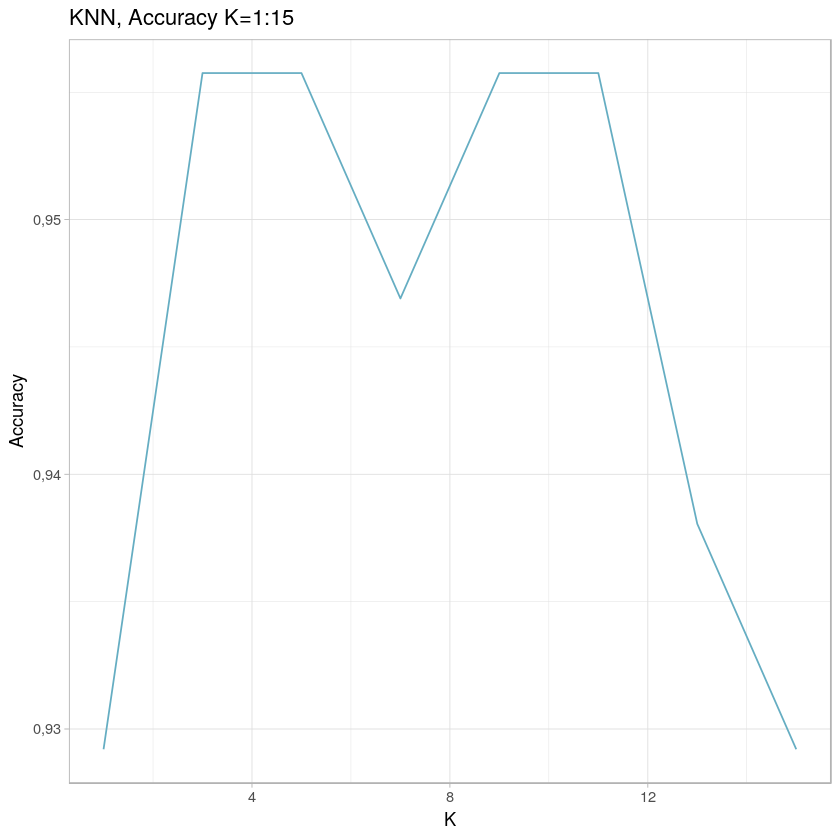

In [135]:
df <- data.frame(K = k_values, Accuracy = unlist(resultados))
ggplot(data = df, aes(x = K, y = Accuracy)) + geom_line()+ theme_light() + ggtitle("KNN, Accuracy K=1:15")

### Resumen
Hasta el momento fuimos capaces de predecir si el tipo de tumor es maligno o benigno como más de un 95% de certeza.

![KNNsalt](/assets/images/KNN.jpg)

Nada mal eh???

Bueno, la realidad es que este dataset es simple de resolver por eso es que aún un método como KNN entrega buenos resultados.

Además nuestro modelado presenta ciertas deficiencias. La más notoria es que no usamos una técnica como validación cruzada (cross-validation). La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba, es decir que nuestros resultados no se vean favorecidos o perjudicados por el dataset de entrenamiento y testeo que utilizamos. Ok Ok más despacio cerebrito. Suena muy bien y muy útil, pero como sería?, simple, miremos la siguiente imagen que es un ejemplo de 5-Fold Cross Validation.

![5fcv](/assets/images/validacion_cruzada.png)

Como se puede observar, la idea es particionar el dataset en un número de folds, en el ejemplo 5, y en cada iteración se utilizan 4 folds para entrenar y el restante para testear, finalmente se promedian los errores y se calcula la varianza.

## Cross Validation

Vamos a realizar 5-Fold cross validation sobre el dataset y vamos a chequear los nuevos resultados.

Primero creamos las 5 particiones del dataset

In [136]:
# Creo 5 particiones
set.seed(87)
data_folds <- createFolds(breast_cancer_n[, "diagnosis"], k = 5, 
                              list = TRUE, returnTrain = FALSE)

In [137]:
str(data_folds)

List of 5
 $ Fold1: int [1:114] 10 15 20 21 22 25 29 31 40 57 ...
 $ Fold2: int [1:115] 6 11 16 17 28 30 32 35 37 51 ...
 $ Fold3: int [1:113] 1 5 8 13 14 19 23 36 49 53 ...
 $ Fold4: int [1:113] 2 4 9 24 41 42 43 44 45 46 ...
 $ Fold5: int [1:114] 3 7 12 18 26 27 33 34 38 39 ...


Ahora vamos a realizar la cross-validation. El codigo a continuación esta dentro de un ciclo FOR. En R no se suelen usar este tipo de ciclos, pero para simplificar sobre todo para posibles lectores que vengan de otros lenguajes, lo implementaremos de esa forma.

Utilizaremos un valor de K = 9.

In [138]:
# Variable para almacenar los resultados
accuracy_list <- list()
# Iteramos los 5 folds
for(i in 1:5) {
      fold_index <- data_folds[[i]]
      X_train <- breast_cancer_n[-fold_index, !(colnames(breast_cancer_n) %in% "diagnosis")]
      X_test <- breast_cancer_n[fold_index, !(colnames(breast_cancer_n) %in% "diagnosis")]
      y_train <- breast_cancer_n[-fold_index, "diagnosis"]
      y_test <- breast_cancer_n[fold_index, "diagnosis"]
      pred <- knn(k = 5, train = X_train, test = X_test, cl = y_train)    
      cm <- as.matrix(table(Predicted = pred, Actual = y_test))
      # Calculo estadísticas del fold
      accuracy <- sum(diag(cm))/sum(cm)
      accuracy_list[[i]] <- accuracy     
}

Ahora vamos a ver el accuracy de cada uno de los 5 folds

In [139]:
accuracy_list

[[1]]
[1] 0,9824561

[[2]]
[1] 0,9652174

[[3]]
[1] 0,9646018

[[4]]
[1] 0,9646018

[[5]]
[1] 0,9649123

Podemos observer que la performance del algoritmo depende del fold, asi la accuracy va desde 96 a 98%.

A continuación la accuracy media y la varianza para un valor de K = 9

In [140]:
mean(unlist(accuracy_list))
var(unlist(accuracy_list))

[1] 0,9683579

[1] 6,217812e-05

Bueno, esto ha sido todo por hoy. En los artículos futuros vamos a ir mejorando esto, y analizando otros datasets, hablaremos más de EDA, otras métricas para evaluar la performance del algoritmo, utilizaremos [caret](https://scikit-learn.org/stable/), un paquete de R muy bueno para machine learning, y también [scikit-learn](https://scikit-learn.org/stable/) en python.
